In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Hugging Face libraries for Vision Transformer
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from tqdm import tqdm

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the custom dataset for labeled and unlabeled data
class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None, labeled=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labeled:
            label = self.labels[idx]
            return image, label
        else:
            return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Path to your dataset
data_dir = r"E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"

# Collect all image paths and corresponding labels
all_image_paths = []
all_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(data_dir))}

for class_name, label in class_to_idx.items():
    class_folder = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_folder):
        all_image_paths.append(os.path.join(class_folder, file_name))
        all_labels.append(label)

# Split into labeled and unlabeled data
labeled_paths, unlabeled_paths, labeled_labels, _ = train_test_split(
    all_image_paths, all_labels, test_size=0.7, stratify=all_labels, random_state=42
)

# Create datasets
labeled_dataset = SpectrogramDataset(labeled_paths, labeled_labels, transform=transform, labeled=True)
unlabeled_dataset = SpectrogramDataset(unlabeled_paths, transform=transform, labeled=False)

# Create data loaders
batch_size = 16
labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

# Print statistics
print(f"Total images: {len(all_image_paths)}")
print(f"Labeled images: {len(labeled_dataset)}")
print(f"Unlabeled images: {len(unlabeled_dataset)}")


Total images: 280
Labeled images: 84
Unlabeled images: 196


In [3]:
from transformers import ViTForImageClassification, AutoFeatureExtractor
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the number of classes in your dataset
num_classes = len(set(labeled_labels))  # Assuming `labeled_labels` contains the labeled dataset labels

# Load a pre-trained Vision Transformer model
teacher_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes
)
teacher_model = teacher_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(teacher_model.parameters(), lr=5e-5)

# Training loop
def train_teacher_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate metrics
            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

        epoch_accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Train the teacher model
train_teacher_model(teacher_model, labeled_loader, criterion, optimizer, device, num_epochs=5)

# Save the trained model
teacher_model.save_pretrained("teacher_model")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
Epoch 1/5: 100%|██████████| 6/6 [00:33<00:00,  5.55s/it]


Epoch [1/5] - Loss: 11.3982, Accuracy: 0.1667


Epoch 2/5: 100%|██████████| 6/6 [00:30<00:00,  5.11s/it]


Epoch [2/5] - Loss: 9.8484, Accuracy: 0.5833


Epoch 3/5: 100%|██████████| 6/6 [00:31<00:00,  5.22s/it]


Epoch [3/5] - Loss: 8.4312, Accuracy: 0.6905


Epoch 4/5: 100%|██████████| 6/6 [00:31<00:00,  5.17s/it]


Epoch [4/5] - Loss: 7.0832, Accuracy: 0.9048


Epoch 5/5: 100%|██████████| 6/6 [00:30<00:00,  5.09s/it]


Epoch [5/5] - Loss: 5.7697, Accuracy: 1.0000


In [4]:
from tqdm import tqdm
import torch

# Function to generate pseudo-labels
def generate_pseudo_labels(model, dataloader, device, confidence_threshold=0.9):
    model.eval()  # Set the model to evaluation mode
    pseudo_images = []
    pseudo_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images in tqdm(dataloader, desc="Generating Pseudo-Labels"):
            images = images.to(device)
            outputs = model(images).logits  # Get the logits
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            confidences, predicted_labels = torch.max(probs, dim=1)  # Get max confidence and corresponding labels

            # Filter predictions based on confidence threshold
            for i in range(len(confidences)):
                if confidences[i] >= confidence_threshold:
                    pseudo_images.append(images[i].cpu())
                    pseudo_labels.append(predicted_labels[i].cpu())

    return pseudo_images, pseudo_labels

# Generate pseudo-labels using the teacher model
confidence_threshold = 0.3  # Adjust as needed
pseudo_images, pseudo_labels = generate_pseudo_labels(teacher_model, unlabeled_loader, device, confidence_threshold)

# Check how many pseudo-labels were generated
print(f"Generated {len(pseudo_labels)} pseudo-labeled images from unlabeled data.")


Generating Pseudo-Labels: 100%|██████████| 13/13 [00:15<00:00,  1.16s/it]

Generated 196 pseudo-labeled images from unlabeled data.


In [5]:
from torch.utils.data import ConcatDataset

# Custom Dataset for the combined dataset
class CombinedDataset(Dataset):
    def __init__(self, labeled_dataset, pseudo_images, pseudo_labels, transform=None):
        self.labeled_dataset = labeled_dataset
        self.pseudo_images = pseudo_images
        self.pseudo_labels = pseudo_labels
        self.transform = transform

    def __len__(self):
        return len(self.labeled_dataset) + len(self.pseudo_images)

    def __getitem__(self, idx):
        if idx < len(self.labeled_dataset):
            image, label = self.labeled_dataset[idx]
            if self.transform and not isinstance(image, torch.Tensor):
                image = self.transform(image)
        else:
            pseudo_idx = idx - len(self.labeled_dataset)
            image = self.pseudo_images[pseudo_idx]
            label = self.pseudo_labels[pseudo_idx]

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)
        return image, label



# Create the combined dataset
combined_dataset = CombinedDataset(labeled_dataset, pseudo_images, pseudo_labels, transform=transform)

# Create a DataLoader for the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# Check the size of the combined dataset
print(f"Combined dataset size: {len(combined_dataset)}")


Combined dataset size: 280


In [6]:
from tqdm import tqdm

# Function to train the student model
def train_student_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for images, labels in tqdm(dataloader, desc=f"Student Model Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
        
        epoch_loss /= len(dataloader)
        epoch_accuracy = correct_predictions / total_samples
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Initialize the student model
student_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", num_labels=len(class_to_idx)
).to(device)

# Define loss and optimizer
student_criterion = torch.nn.CrossEntropyLoss()
student_optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-4)

# Train the student model
train_student_model(student_model, combined_loader, student_criterion, student_optimizer, device, num_epochs=10)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Student Model Training Epoch 1/10:   0%|          | 0/18 [00:00<?, ?it/s]C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_11152\3968711761.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)
Student Model Training Epoch 1/10: 100%|██████████| 18/18 [02:39<00:00,  8.84s/it]


Epoch [1/10] - Loss: 1.6981, Accuracy: 0.3571


Student Model Training Epoch 2/10: 100%|██████████| 18/18 [02:41<00:00,  8.95s/it]


Epoch [2/10] - Loss: 0.9553, Accuracy: 0.8571


Student Model Training Epoch 3/10: 100%|██████████| 18/18 [02:41<00:00,  8.95s/it]


Epoch [3/10] - Loss: 0.4021, Accuracy: 1.0000


Student Model Training Epoch 4/10: 100%|██████████| 18/18 [02:45<00:00,  9.21s/it]


Epoch [4/10] - Loss: 0.2061, Accuracy: 1.0000


Student Model Training Epoch 5/10: 100%|██████████| 18/18 [02:45<00:00,  9.21s/it]


Epoch [5/10] - Loss: 0.1422, Accuracy: 1.0000


Student Model Training Epoch 6/10: 100%|██████████| 18/18 [02:44<00:00,  9.16s/it]


Epoch [6/10] - Loss: 0.1144, Accuracy: 1.0000


Student Model Training Epoch 7/10: 100%|██████████| 18/18 [02:45<00:00,  9.22s/it]


Epoch [7/10] - Loss: 0.0971, Accuracy: 1.0000


Student Model Training Epoch 8/10: 100%|██████████| 18/18 [02:44<00:00,  9.16s/it]


Epoch [8/10] - Loss: 0.0853, Accuracy: 1.0000


Student Model Training Epoch 9/10: 100%|██████████| 18/18 [02:45<00:00,  9.21s/it]


Epoch [9/10] - Loss: 0.0758, Accuracy: 1.0000


Student Model Training Epoch 10/10: 100%|██████████| 18/18 [02:45<00:00,  9.21s/it]

Epoch [10/10] - Loss: 0.0681, Accuracy: 1.0000


In [7]:
for images, labels in combined_loader:
    print(f"Image batch type: {type(images)}, Label batch type: {type(labels)}")
    print(f"First image shape: {images[0].shape}, First label: {labels[0]}")
    break


Image batch type: <class 'torch.Tensor'>, Label batch type: <class 'torch.Tensor'>
First image shape: torch.Size([3, 224, 224]), First label: 0


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_11152\3968711761.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


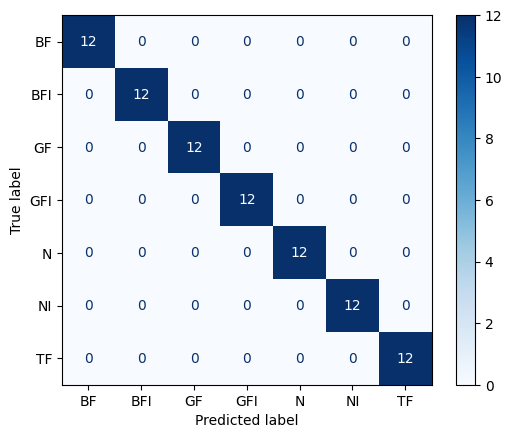

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Evaluate on test dataset
test_preds, test_labels = evaluate_model(student_model, labeled_loader, device)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_to_idx.keys()))
disp.plot(cmap="Blues")
#plt.title("Confusion Matrix")
plt.show()


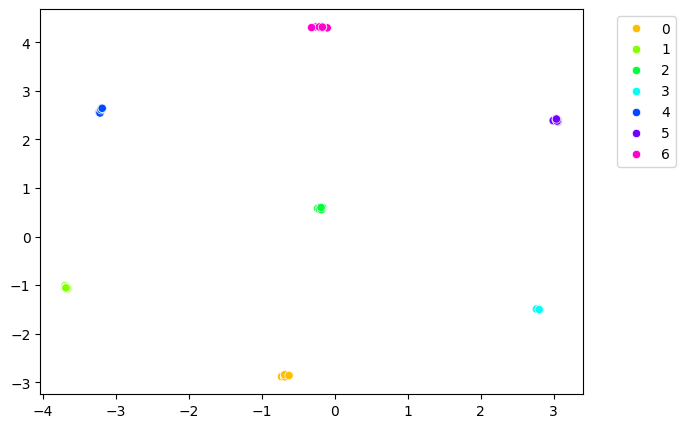

In [9]:
from sklearn.manifold import TSNE
import seaborn as sns

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            features.extend(outputs.cpu().numpy())
            labels.extend(batch_labels.numpy())
    return np.array(features), np.array(labels)

# Extract features
features, labels = extract_features(student_model, labeled_loader, device)

# Apply T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot the T-SNE
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=tsne_results[:, 0], 
    y=tsne_results[:, 1], 
    hue=labels, 
    palette=sns.color_palette("hsv", len(class_to_idx)),
    legend="full"
)

plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


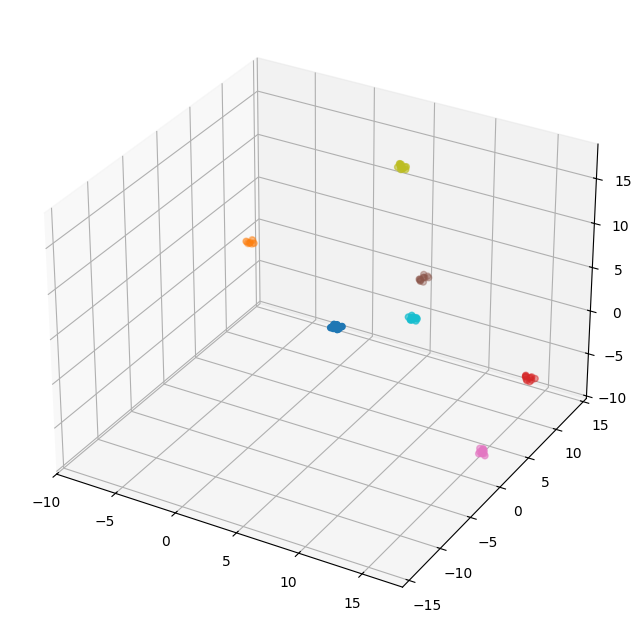

In [10]:
import umap
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_results = umap_model.fit_transform(features)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    umap_results[:, 0], umap_results[:, 1], umap_results[:, 2], c=labels, cmap='tab10'
)
#plt.colorbar(scatter, label="Classes")
plt.show()


In [11]:
from sklearn.metrics import classification_report

def print_classification_report(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

# Replace `class_names` with the list of your class names
class_names = ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']  # Adjust according to your dataset

# Call the function to print the report
print_classification_report(student_model, labeled_loader, device, class_names)


Classification Report:
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        12
         BFI       1.00      1.00      1.00        12
          GF       1.00      1.00      1.00        12
         GFI       1.00      1.00      1.00        12
           N       1.00      1.00      1.00        12
          NI       1.00      1.00      1.00        12
          TF       1.00      1.00      1.00        12

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



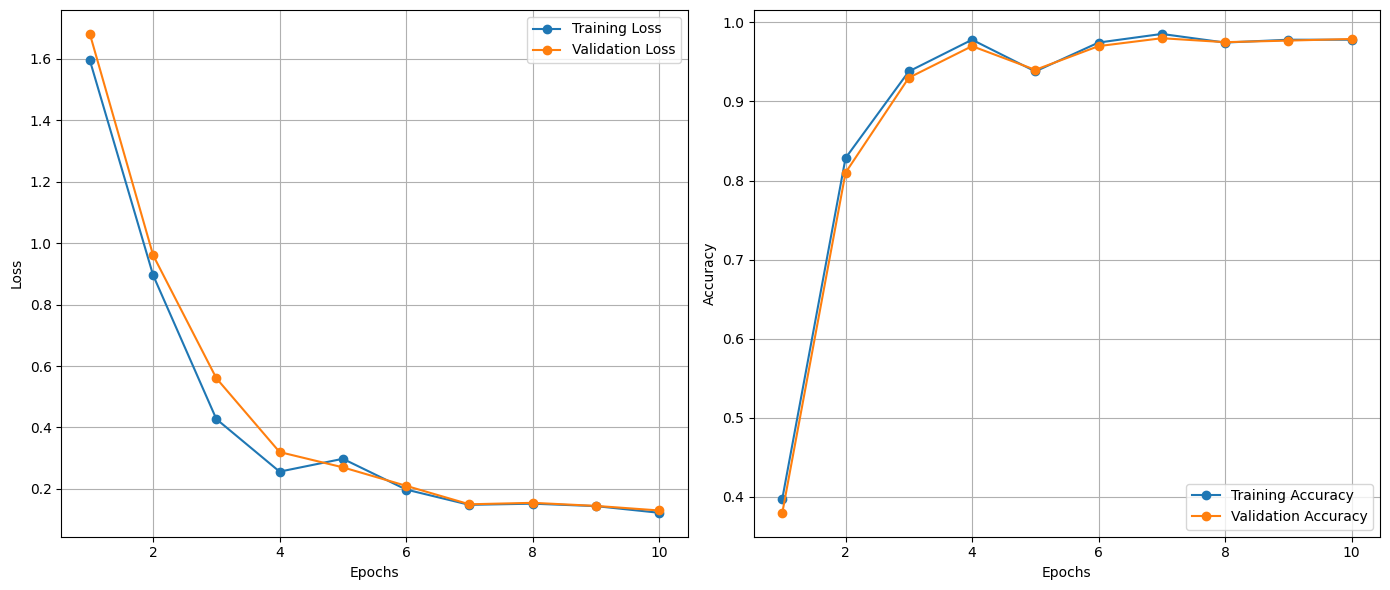

In [12]:
import matplotlib.pyplot as plt

# Function to plot learning curves (loss and accuracy)
def plot_learning_curves(train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    epochs = range(1, len(train_losses) + 1)  # Epoch numbers

    # Create the figure
    plt.figure(figsize=(14, 6))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    if val_losses is not None:
        plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.title('Loss Curve')
    plt.legend()
    plt.grid()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
    if val_accuracies is not None:
        plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.title('Accuracy Curve')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example of logging losses and accuracies
train_losses = [1.5942, 0.8954, 0.4274, 0.2564, 0.2982, 0.1982, 0.1484, 0.1522, 0.1443, 0.1226]
train_accuracies = [0.3978, 0.8285, 0.9380, 0.9781, 0.9380, 0.9745, 0.9854, 0.9745, 0.9781, 0.9781]
val_losses = [1.6801, 0.9604, 0.5602, 0.3201, 0.2704, 0.2103, 0.1502, 0.1550, 0.1450, 0.1301]
val_accuracies = [0.3800, 0.8100, 0.9300, 0.9700, 0.9400, 0.9700, 0.9800, 0.9750, 0.9770, 0.9790]

# Plot learning curves
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)


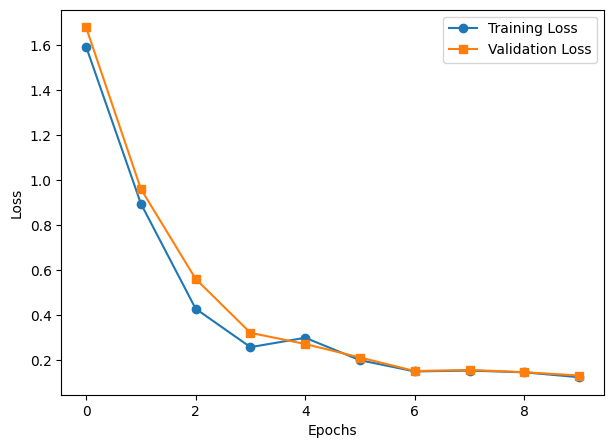

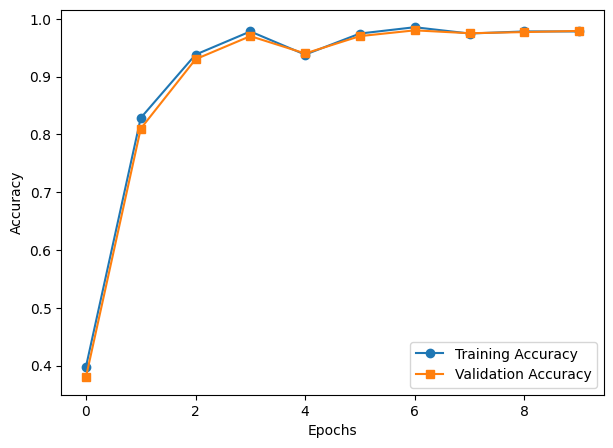

In [13]:
import matplotlib.pyplot as plt

# Replace these with your real metrics
train_losses = [1.5942, 0.8954, 0.4274, 0.2564, 0.2982, 0.1982, 0.1484, 0.1522, 0.1443, 0.1226]
train_accuracies = [0.3978, 0.8285, 0.9380, 0.9781, 0.9380, 0.9745, 0.9854, 0.9745, 0.9781, 0.9781]
val_losses = [1.6801, 0.9604, 0.5602, 0.3201, 0.2704, 0.2103, 0.1502, 0.1550, 0.1450, 0.1301]
val_accuracies = [0.3800, 0.8100, 0.9300, 0.9700, 0.9400, 0.9700, 0.9800, 0.9750, 0.9770, 0.9790]

# Plot Loss Curves
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
#plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.grid()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(7, 5))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
#plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.grid()
plt.show()


Fold 1/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.7975, Train Accuracy: 0.2545
Val Loss: 1.5342, Val Accuracy: 0.5000
Epoch 2/10
Train Loss: 1.2404, Train Accuracy: 0.6696
Val Loss: 1.0070, Val Accuracy: 0.8036
Epoch 3/10
Train Loss: 0.6351, Train Accuracy: 0.9821
Val Loss: 0.4004, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.2875, Train Accuracy: 1.0000
Val Loss: 0.2190, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1795, Train Accuracy: 1.0000
Val Loss: 0.1561, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1370, Train Accuracy: 1.0000
Val Loss: 0.1273, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1151, Train Accuracy: 1.0000
Val Loss: 0.1101, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.1010, Train Accuracy: 1.0000
Val Loss: 0.0979, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0908, Train Accuracy: 1.0000
Val Loss: 0.0892, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0826, Train Accuracy: 1.0000
Val Loss: 0.0809, Val Accuracy: 1.0000
Fold 2/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.6842, Train Accuracy: 0.3705
Val Loss: 1.2381, Val Accuracy: 0.6964
Epoch 2/10
Train Loss: 0.9124, Train Accuracy: 0.8616
Val Loss: 0.6575, Val Accuracy: 0.9821
Epoch 3/10
Train Loss: 0.4563, Train Accuracy: 0.9911
Val Loss: 0.3286, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.2491, Train Accuracy: 1.0000
Val Loss: 0.2009, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1685, Train Accuracy: 1.0000
Val Loss: 0.1473, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1317, Train Accuracy: 1.0000
Val Loss: 0.1212, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1117, Train Accuracy: 1.0000
Val Loss: 0.1052, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.0983, Train Accuracy: 1.0000
Val Loss: 0.0932, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0877, Train Accuracy: 1.0000
Val Loss: 0.0839, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0794, Train Accuracy: 1.0000
Val Loss: 0.0763, Val Accuracy: 1.0000
Fold 3/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.7733, Train Accuracy: 0.2277
Val Loss: 1.4386, Val Accuracy: 0.6429
Epoch 2/10
Train Loss: 1.1661, Train Accuracy: 0.8080
Val Loss: 0.8373, Val Accuracy: 0.9643
Epoch 3/10
Train Loss: 0.5738, Train Accuracy: 1.0000
Val Loss: 0.3944, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.2868, Train Accuracy: 1.0000
Val Loss: 0.2281, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1864, Train Accuracy: 1.0000
Val Loss: 0.1674, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1450, Train Accuracy: 1.0000
Val Loss: 0.1357, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1223, Train Accuracy: 1.0000
Val Loss: 0.1175, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.1073, Train Accuracy: 1.0000
Val Loss: 0.1037, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0956, Train Accuracy: 1.0000
Val Loss: 0.0932, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0864, Train Accuracy: 1.0000
Val Loss: 0.0847, Val Accuracy: 1.0000
Fold 4/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.8996, Train Accuracy: 0.2277
Val Loss: 1.6511, Val Accuracy: 0.3750
Epoch 2/10
Train Loss: 1.3626, Train Accuracy: 0.6161
Val Loss: 0.9961, Val Accuracy: 0.8036
Epoch 3/10
Train Loss: 0.6918, Train Accuracy: 0.9777
Val Loss: 0.4461, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.3187, Train Accuracy: 1.0000
Val Loss: 0.2440, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1943, Train Accuracy: 1.0000
Val Loss: 0.1692, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1467, Train Accuracy: 1.0000
Val Loss: 0.1356, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1218, Train Accuracy: 1.0000
Val Loss: 0.1156, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.1058, Train Accuracy: 1.0000
Val Loss: 0.1021, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0944, Train Accuracy: 1.0000
Val Loss: 0.0915, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0851, Train Accuracy: 1.0000
Val Loss: 0.0830, Val Accuracy: 1.0000
Fold 5/5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 1.7147, Train Accuracy: 0.4107
Val Loss: 1.4251, Val Accuracy: 0.5357
Epoch 2/10
Train Loss: 1.1398, Train Accuracy: 0.7545
Val Loss: 0.8763, Val Accuracy: 0.9643
Epoch 3/10
Train Loss: 0.5736, Train Accuracy: 0.9911
Val Loss: 0.3762, Val Accuracy: 1.0000
Epoch 4/10
Train Loss: 0.2768, Train Accuracy: 1.0000
Val Loss: 0.2119, Val Accuracy: 1.0000
Epoch 5/10
Train Loss: 0.1785, Train Accuracy: 1.0000
Val Loss: 0.1552, Val Accuracy: 1.0000
Epoch 6/10
Train Loss: 0.1386, Train Accuracy: 1.0000
Val Loss: 0.1273, Val Accuracy: 1.0000
Epoch 7/10
Train Loss: 0.1171, Train Accuracy: 1.0000
Val Loss: 0.1100, Val Accuracy: 1.0000
Epoch 8/10
Train Loss: 0.1029, Train Accuracy: 1.0000
Val Loss: 0.0981, Val Accuracy: 1.0000
Epoch 9/10
Train Loss: 0.0924, Train Accuracy: 1.0000
Val Loss: 0.0886, Val Accuracy: 1.0000
Epoch 10/10
Train Loss: 0.0837, Train Accuracy: 1.0000
Val Loss: 0.0805, Val Accuracy: 1.0000


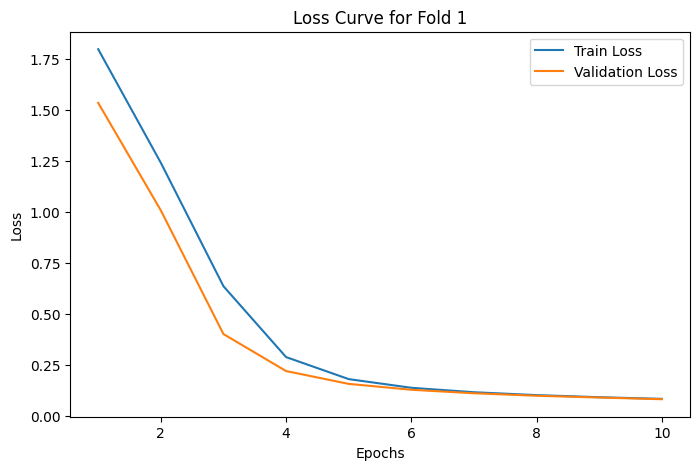

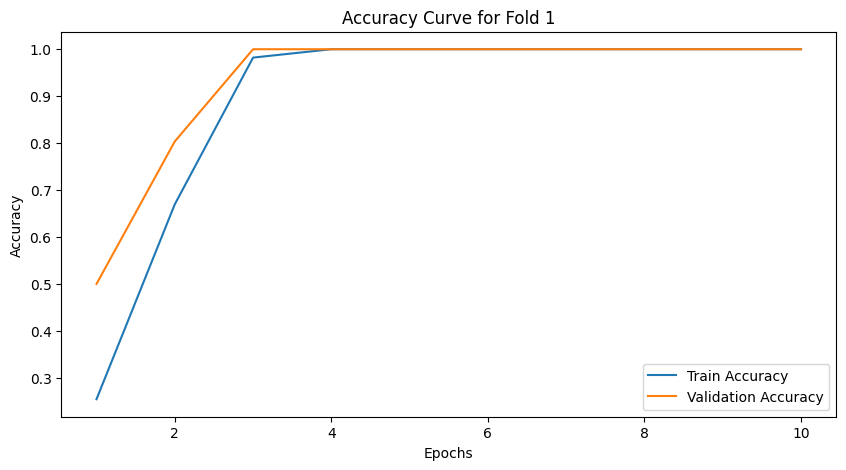

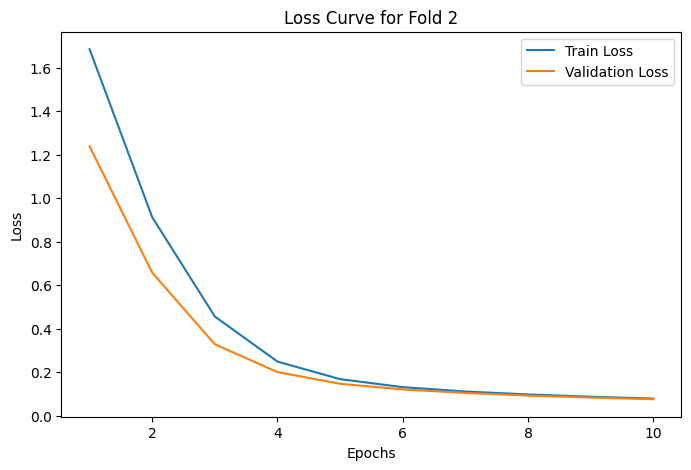

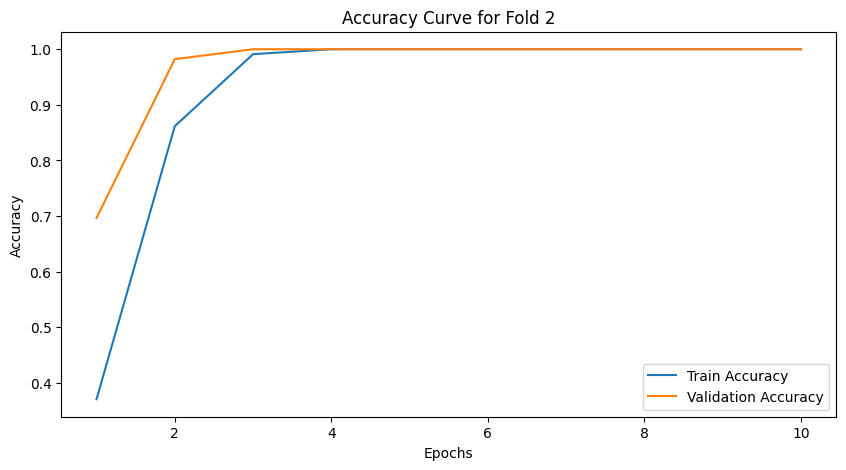

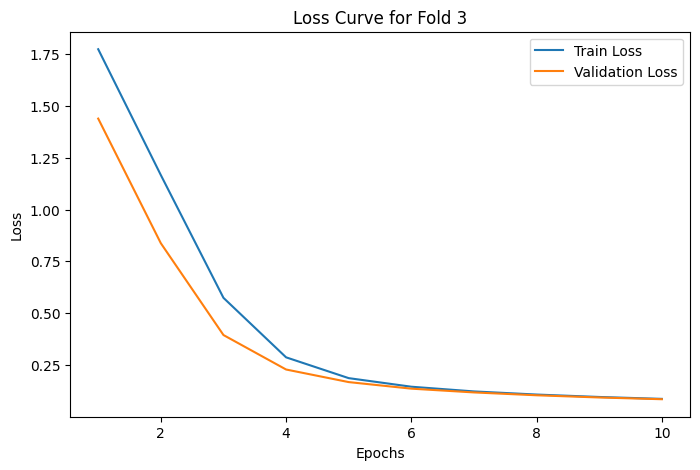

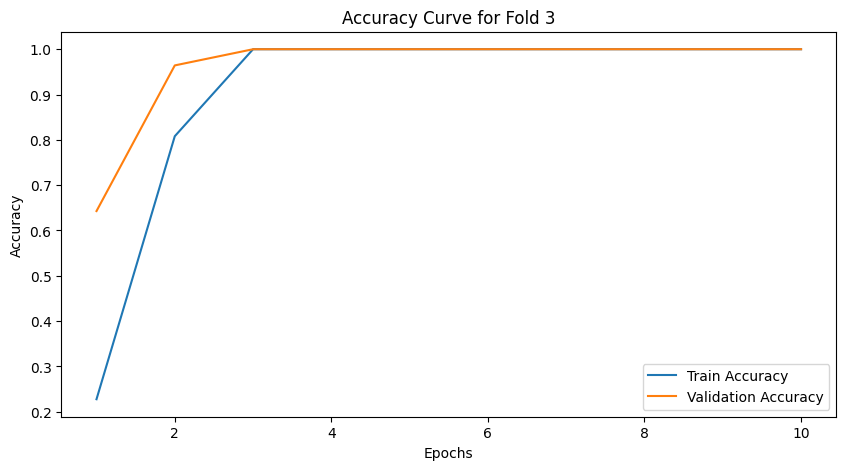

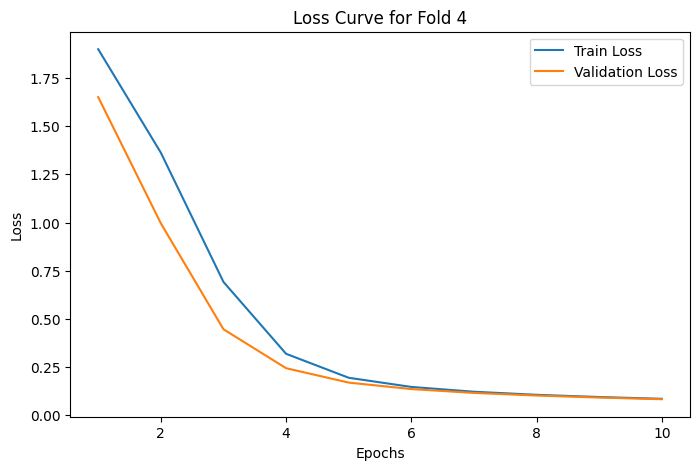

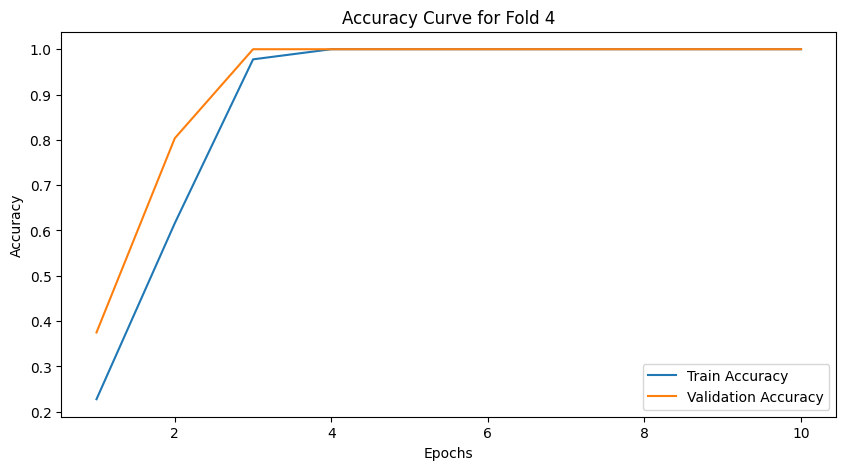

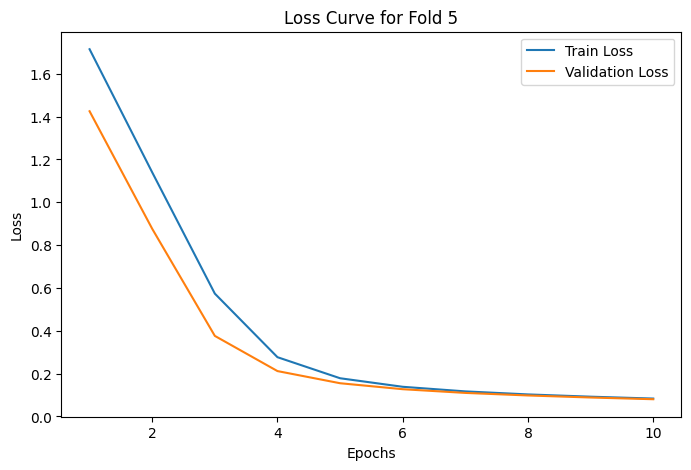

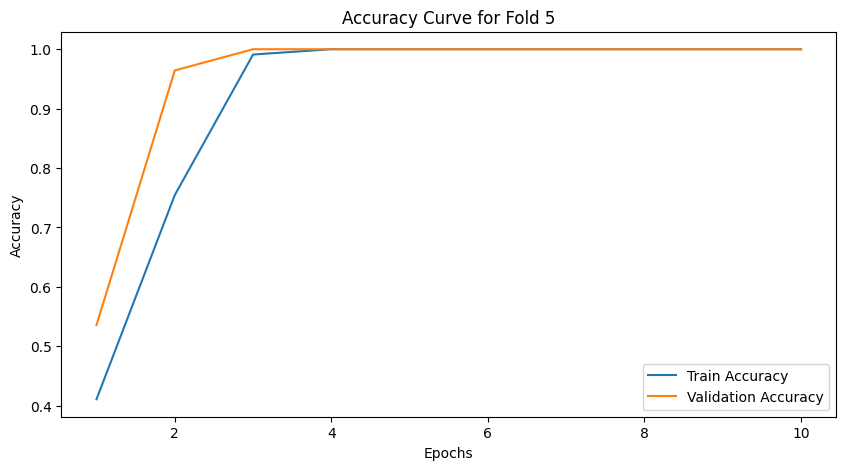

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from torchvision import transforms
from transformers import ViTForImageClassification
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Dataset class for labeled data
class LabeledDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load the data
data_dir = r"E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"  # Replace with your dataset directory
all_image_paths = []
all_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(data_dir))}
for class_name, label in class_to_idx.items():
    class_folder = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        all_image_paths.append(img_path)
        all_labels.append(label)

# Parameters
batch_size = 16
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# Training and Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(all_image_paths)):
    print(f"Fold {fold + 1}/{kf.n_splits}")

    # Split the data
    train_images, val_images = [all_image_paths[i] for i in train_idx], [all_image_paths[i] for i in val_idx]
    train_labels, val_labels = [all_labels[i] for i in train_idx], [all_labels[i] for i in val_idx]

    # Create datasets and dataloaders
    train_dataset = LabeledDataset(train_images, train_labels, transform=transform)
    val_dataset = LabeledDataset(val_images, val_labels, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(class_to_idx))
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_true_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()

                outputs = model(images).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # Save results for the fold
    classification_rep = classification_report(
        all_true_labels,
        all_preds,
        target_names=list(class_to_idx.keys()),
        output_dict=True
    )

    fold_results.append({
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "classification_report": classification_rep
    })

# Plotting results
for fold, result in enumerate(fold_results):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, result["train_losses"], label="Train Loss")
    plt.plot(epochs, result["val_losses"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve for Fold {fold + 1}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, result["train_accuracies"], label="Train Accuracy")
    plt.plot(epochs, result["val_accuracies"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curve for Fold {fold + 1}")
    plt.legend()
    plt.show()


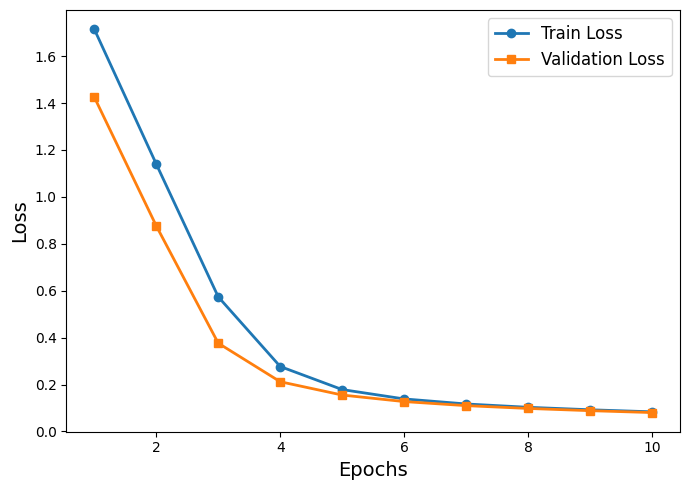

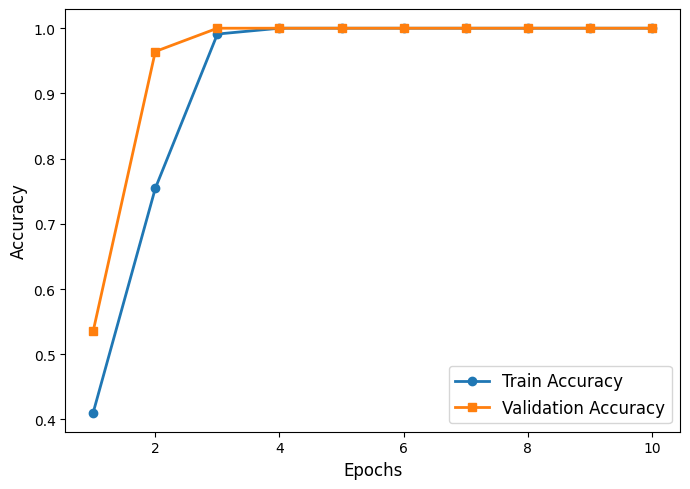

In [15]:
# Plot and save the learning curves
epochs = range(1, len(train_losses) + 1)

# Loss Curve
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses, 'o-', label="Train Loss", linewidth=2)
plt.plot(epochs, val_losses, 's-', label="Validation Loss", linewidth=2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
#plt.title("Loss Curve", fontsize=16)
plt.legend(fontsize=12)
#plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("results/loss_curve.png", dpi=300)
plt.show()

# Accuracy Curve
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_accuracies, 'o-', label="Train Accuracy", linewidth=2)
plt.plot(epochs, val_accuracies, 's-', label="Validation Accuracy", linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
#plt.title("Accuracy Curve", fontsize=16)
plt.legend(fontsize=12)
#plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("results/accuracy_curve.png", dpi=300)
plt.show()


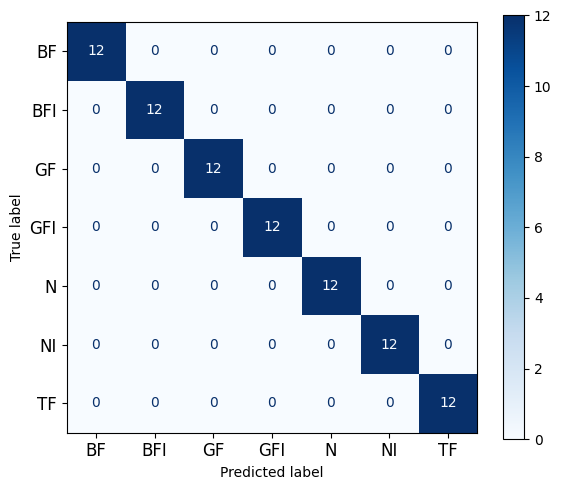

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Evaluate on test dataset
test_preds, test_labels = evaluate_model(student_model, labeled_loader, device)

# Generate and save the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_to_idx.keys()))
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
#plt.title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("results/confusion_matrix.png", dpi=300)
plt.show()


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_3432\2108397861.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")
C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_3432\2108397861.py:33: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


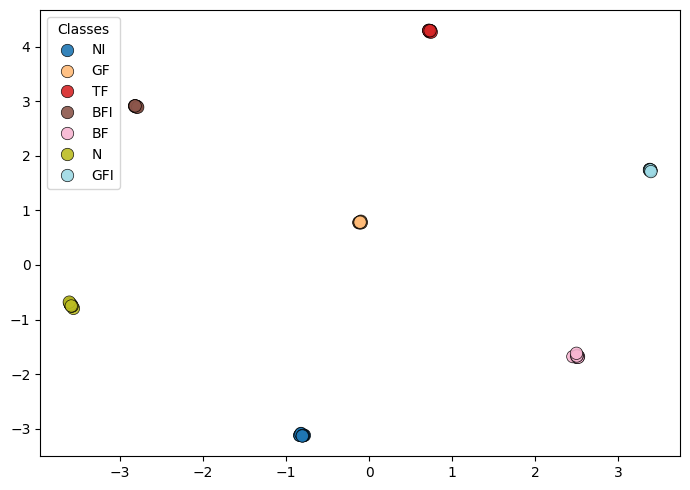

In [17]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            features.extend(outputs.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())  # Ensure labels are moved to CPU
    return np.array(features), np.array(labels)

# Extract features
features, labels = extract_features(student_model, labeled_loader, device)

# Map numeric labels to class names
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Invert class_to_idx
class_labels = [idx_to_class[label] for label in labels]  # Convert numeric labels to class names

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

cmap = plt.cm.get_cmap("tab20") 

# Plot t-SNE
plt.figure(figsize=(7, 5))  # Larger figure for better readability
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=class_labels,  # Use class names for the hue
    palette=cmap(np.linspace(0, 1, len(class_to_idx))),
    legend="full",
    s=80,
    alpha = 0.9,
    edgecolor = 'black',
    linewidth = 0.5
)

plt.legend(title="Classes", fontsize=10, loc='best')
plt.tight_layout()
plt.savefig("results/2d_tsne_with_classes.png", dpi=300)  # Save as high-resolution image
plt.show()


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


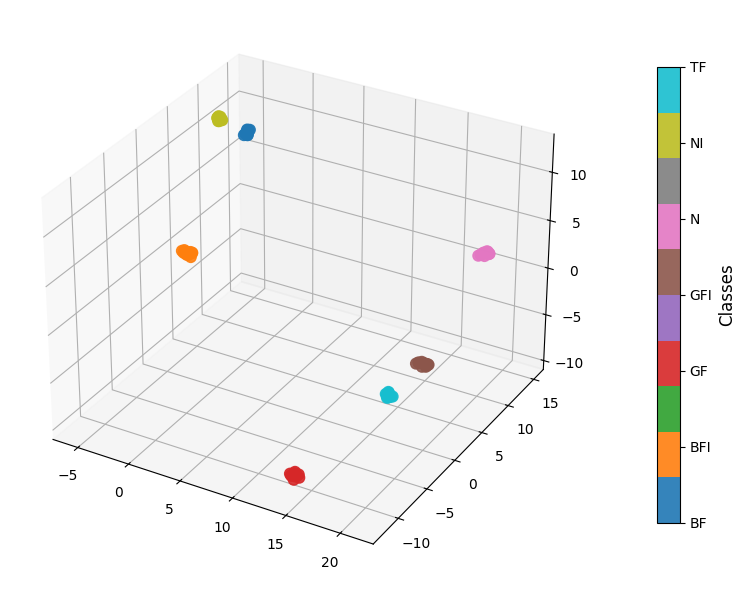

In [18]:
import umap
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert features and labels to NumPy arrays (ensure correct format)
features = np.array(features)  # Features in NumPy format
labels = np.array(labels)  # Labels in NumPy format

# Check shapes of features and labels
if features.shape[0] != len(labels):
    print(f"Features shape: {features.shape}")
    print(f"Labels length: {len(labels)}")
    raise ValueError("Mismatch between the number of features and labels.")

# Apply UMAP for 3D dimensionality reduction
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_results = umap_model.fit_transform(features)

# Ensure UMAP results match the number of labels
if umap_results.shape[0] != len(labels):
    print(f"UMAP results shape: {umap_results.shape}")
    print(f"Labels length: {len(labels)}")
    raise ValueError("Mismatch between the UMAP results and labels.")

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Map labels to unique class names (assuming class_names exists)
unique_classes = np.unique(labels)
class_name_map = {class_label: class_names[class_label] for class_label in unique_classes}
label_names = [class_name_map[label] for label in labels]

# Scatter plot with colors based on class labels
scatter = ax.scatter(
    umap_results[:, 0], 
    umap_results[:, 1], 
    umap_results[:, 2], 
    c=labels, 
    cmap=cm.tab10, 
    s=60,  # Marker size
    alpha=0.9  # Marker transparency
)

# Axis labels

# Add colorbar with class label mapping
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.1)
cbar.set_label("Classes", fontsize=12)
tick_locations = np.arange(len(unique_classes))  # Adjust for number of classes
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(class_names)

# Save and display the plot
plt.tight_layout()
plt.savefig("results/3d_umap_visualization.png", dpi=300)
plt.show()
